# Using kallisto BUS to extract hashtag oligos (HTO) and cell barcodes

## Downloading the data

### This notebook uses only dataset `GSM2895283: Hashtag-HTO; Homo sapiens; RNA-Seq(SRR8281307)`

GSM2895283 entry: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2895283

SRR8281307 entry: https://www.ncbi.nlm.nih.gov/Traces/study/?acc=SRP127179


**Publication: Cell hashing enable sample multiplexing, multiplet identification and super-loading on droplet-based single cell RNA-sequencing platforms**
Published on Genome Biology: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1603-1

The GEO entry associated with this study is GSE108313: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108313

In the cell hashing paper datasets, ADT means AntiboDy Tag (used in the citeseq epitope mapping method), HTO means Hash Tag Oligo (used in cell hashing multiplexing method) and RNA means the actual transcript reads, which must be cross referenced with the ADT and HTO data.

These experiments are split across 3 datasets:
```
GSM2895284: Hashtag-ADT; Homo sapiens; RNA-Seq(SRR8281308) ~ 35GB unzipped
GSM2895283: Hashtag-HTO; Homo sapiens; RNA-Seq(SRR8281307) ~ 30GB unzipped
GSM2895282: Hashtag-RNA; Homo sapiens; RNA-Seq(SRR8281306) ~ 253GB unzipped
```

To download it we use fasterq-dump is a folder named `data`. It takes a while because files are big.

In this notebook we only use entry `SRR8281307`, which is a paired end read dataset. You can download it with the command `fasterq-dump SRR8281307`, which after it finishes will create two files: `SRR8281307_1.fastq` for read 1 and `SRR8281307_2.fastq` for read 2. Instructions on installing `fasterq-dump`: https://github.com/ncbi/sra-tools/wiki/HowTo:-fasterq-dump. Please note that fastqerq dump does not support downloading files as gzip, so you need to have a lot of disk space avilable. You can user the slower fastq-dump however, which has a gzip option. See usage here: https://edwards.sdsu.edu/research/fastq-dump/

These files are also mirroed by the European Nucleotide Archive, and you can get ftp links to download them here: https://www.ebi.ac.uk/ena/data/view/SRR8281308





# The cell hashtag oligo structure


The hashtag oligos (HTO) used in the cell hashing paper have the following structure, which results in the sequence `xxxxxxxxxxxx` showing at the beginning of read 2 when using 10x v2 chemistry
```
Hashtag oligo struture:
GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTxxxxxxxxxxxxBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA*A*A

x: Hashtag sequence
B: T,G,C, not A
*: Phosphorothioate bond
```

They used the following hashtag sequences in the article to multiplex 8 PBMC samples from different donors:

```
hashtag A: AGGACCATCCAA
hashtag B: ACATGTTACCGT
hashtag C: AGCTTACTATCC
hashtag D: TCGATAATGCGA
hashtag E: GAGGCTGAGCTA
hashtag F: GTGTGACGTATT
hashtag G: ACTGTCTAACGG
hashtag H: TATCACATCGGT
```

For example, if we look at the paired end read number 9999981 of entry SRR8281307, we see the following (you can see the reads online here: 
https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?run=SRR8281307)

```
>gnl|SRA|SRR8281307.9999981.1 9999981 (Biological)
TGGGCGTAGAAGATTCAGTTTTATTGTTT
```

```
>gnl|SRA|SRR8281307.9999981.2 9999981 (Biological)
TATCACATCGGTCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACGGAGTTTT
TTTGGCCAAAAAATGGAAAGGGGCGTCAAAGAAAAAAAA
```

You can see that the first 12 bases of read 2 correspond to the hashtag H, `TATCACATCGGT`, which is followed by a `B`, which is `C,T,G` but not `A`, and then the poly(A) sequence.

# Retrieving tags for sample demultiplexing with kallisto bus

kallisto bus, introduced in v0.45, allows us to quickly demultiplex single cell samples by just having a list of acceptable tags, regardless of where the tag appears.

To do so, instead of looking for transcript fragments of length `k` (the `k-mer` length) in the reads, which is what kallisto usually does, we look for tag fragments of lenght `k`. Thus, instead of building a transcriptome index and using kallisto bus as normal, we build an index from the list of tags and use kallisto bus as usual. The result will be a BUS file: a list of the cell barcode, UMI, tag equivalence class, and multiplicity (how many times the same entry was found). Because tags are designed to ber far appart from each other in the sequence space, each k-mer should map uniquely to one tag, thus the tag equivalence class should have a one-to-one correspondence to a hashtag (A-H) 

In the cell hashing study, the hashtag sequences have length 12, followed by `C,T,G`. Because kallisto needs to use an odd value for `k`, we have two options: 
We could use a smaller k-mer (11 or 9) or we could extend the barcode sequence by appending one extra base in our list of expected barcode, using `k = 13`, which is what we do here. If the sequence flanking the barcodes is constant, we just include them and that's it. In the cell hashing tag structure they are folowed by a `B`, which is `C,T,G` but not `A`, so for each hashtag we need to make 3 variants. So for example, for hashtag A we use the following sequences:

```
hashtagA-C: AGGACCATCCAAC
hashtagA-T: AGGACCATCCAAT
hashtagA-G: AGGACCATCCAAG
```

Thus the 8 original tags become 24. We could just use those 24 extended hashtags to build our index and things would work fine, but kallisto does only perform exact matches. So a read that has a single letter mismatch in the tag would be thrown away, and give that's about 1-2% of the reads, we can do a little better. The solution is to use a list of all the correct tags plus each tag sequence with one mismatch (hamming distance 1). Since each tag is length 12, and each site can mutate to the 3 other bases, that becomes `3*12 = 36` new sequences, plus the correct sequence, so 37. 

So because we're extending each tag sequence in 3 different ways, in total we're building the index with `8*37*3 = 888` sequences

Because the mapping will be one-to-one, collapsing them to retrieve the 8 original sequences is very straightforward with pandas. 

After doing the UMI collapsing, we will have a count matrix of cell barcodes by hashtag (`HTO_count_matrix`), which we can use to decide which hashtag to ascribe to each barcode, and then demultiplex the data.

One we have the `HTO_count_matrix`, the sample transcript demultiplexing is done in a different. It is performed on the dataset `GSM2895282: Hashtag-RNA; Homo sapiens; RNA-Seq(SRR8281306)`, which is about 253GB unzipped.

# Building the extended tag fasta

In this section we take the 8 original hashtag sequences and make a fasta file containing the 888 variations descrived above

In [1]:
from collections import OrderedDict
from Bio import SeqIO
import os
import time
import pandas as pd
import copy
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import scipy
import numpy as np
import anndata
import matplotlib.pyplot as plt
import scipy
from matplotlib.pyplot import figure
import umap
from scipy import io
from sklearn.decomposition import TruncatedSVD
import sklearn
from sklearn.metrics import confusion_matrix
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

notebook_start_time=time.time()


In [2]:
work_folder = './'
data_folder = '/home/munfred/hashing/data'
write_folder = './'

In [3]:
## set parameters - below are parameters for 10x 3' v2 chemistry
## the cell hashing method uses tags of length 12, we included the variable B (T,C,G) in the end to make it lenght 13
cell_barcode_length = 16
UMI_length = 10
sample_tag_length=13

In [4]:
# this cell just writes the 24 extended tags to a fasta file, HTO_tags_len13.fasta, so that the notebook can be run standalone 
# (except for the dataset SRR8281307, which you still need to download)

HTO_fastq_tags= """>hashtagA-T
AGGACCATCCAAT
>hashtagB-T
ACATGTTACCGTT
>hashtagC-T
AGCTTACTATCCT
>hashtagD-T
TCGATAATGCGAT
>hashtagE-T
GAGGCTGAGCTAT
>hashtagF-T
GTGTGACGTATTT
>hashtagG-T
ACTGTCTAACGGT
>hashtagH-T
TATCACATCGGTT
>hashtagA-C
AGGACCATCCAAC
>hashtagB-C
ACATGTTACCGTC
>hashtagC-C
AGCTTACTATCCC
>hashtagD-C
TCGATAATGCGAC
>hashtagE-C
GAGGCTGAGCTAC
>hashtagF-C
GTGTGACGTATTC
>hashtagG-C
ACTGTCTAACGGC
>hashtagH-C
TATCACATCGGTC
>hashtagA-G
AGGACCATCCAAG
>hashtagB-G
ACATGTTACCGTG
>hashtagC-G
AGCTTACTATCCG
>hashtagD-G
TCGATAATGCGAG
>hashtagE-G
GAGGCTGAGCTAG
>hashtagF-G
GTGTGACGTATTG
>hashtagG-G
ACTGTCTAACGGG
>hashtagH-G
TATCACATCGGTG
"""

tags_file_path = os.path.join(write_folder, "HTO_tags_len13.fasta")
tags_file = open(tags_file_path, "w")
tags_file.write(HTO_fastq_tags)
tags_file.close()

In [5]:
"""
This function returns all sample tags and and their single base mismatches (hamming distance 1).
It only mutates the first 12 bases, which are the barcode bases
"""

"parse the tags file and output the set of tag sequences"

def parse_tags(filename):
    odict = OrderedDict()
    print('Read the following tags:')
    for record in SeqIO.parse(filename, "fasta"):
        counter=0
        print(record.seq)
        odict[record.name] = str(record.seq)[:sample_tag_length]
        for pos in range(sample_tag_length):
            if pos == sample_tag_length -1: break
            letter =str(record.seq)[pos]
            barcode=list(str(record.seq)[:+sample_tag_length])
            if letter=='A':
                barcode[pos]='T'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='G'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='C'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
            elif letter=='G':
                barcode[pos]='T'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='A'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='C'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
            elif letter=='C':
                barcode[pos]='T'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='G'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='A'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
            else:
                barcode[pos]='A'
                odict[record.name+'-'+str(pos)+'-1'] = "".join(barcode)
                barcode[pos]='G'
                odict[record.name+'-'+str(pos)+'-2'] = "".join(barcode)
                barcode[pos]='C'
                odict[record.name+'-'+str(pos)+'-3'] = "".join(barcode)
                
    return odict

In [6]:
tag_map=parse_tags(tags_file_path)

Read the following tags:
AGGACCATCCAAT
ACATGTTACCGTT
AGCTTACTATCCT
TCGATAATGCGAT
GAGGCTGAGCTAT
GTGTGACGTATTT
ACTGTCTAACGGT
TATCACATCGGTT
AGGACCATCCAAC
ACATGTTACCGTC
AGCTTACTATCCC
TCGATAATGCGAC
GAGGCTGAGCTAC
GTGTGACGTATTC
ACTGTCTAACGGC
TATCACATCGGTC
AGGACCATCCAAG
ACATGTTACCGTG
AGCTTACTATCCG
TCGATAATGCGAG
GAGGCTGAGCTAG
GTGTGACGTATTG
ACTGTCTAACGGG
TATCACATCGGTG


In [7]:
len(tag_map)

888

In [8]:
# take a look at the tag dictionary, which includes 1 hamming distance versions of all valid tags
list(tag_map.items())[:50]

[('hashtagA-T', 'AGGACCATCCAAT'),
 ('hashtagA-T-0-1', 'TGGACCATCCAAT'),
 ('hashtagA-T-0-2', 'GGGACCATCCAAT'),
 ('hashtagA-T-0-3', 'CGGACCATCCAAT'),
 ('hashtagA-T-1-1', 'ATGACCATCCAAT'),
 ('hashtagA-T-1-2', 'AAGACCATCCAAT'),
 ('hashtagA-T-1-3', 'ACGACCATCCAAT'),
 ('hashtagA-T-2-1', 'AGTACCATCCAAT'),
 ('hashtagA-T-2-2', 'AGAACCATCCAAT'),
 ('hashtagA-T-2-3', 'AGCACCATCCAAT'),
 ('hashtagA-T-3-1', 'AGGTCCATCCAAT'),
 ('hashtagA-T-3-2', 'AGGGCCATCCAAT'),
 ('hashtagA-T-3-3', 'AGGCCCATCCAAT'),
 ('hashtagA-T-4-1', 'AGGATCATCCAAT'),
 ('hashtagA-T-4-2', 'AGGAGCATCCAAT'),
 ('hashtagA-T-4-3', 'AGGAACATCCAAT'),
 ('hashtagA-T-5-1', 'AGGACTATCCAAT'),
 ('hashtagA-T-5-2', 'AGGACGATCCAAT'),
 ('hashtagA-T-5-3', 'AGGACAATCCAAT'),
 ('hashtagA-T-6-1', 'AGGACCTTCCAAT'),
 ('hashtagA-T-6-2', 'AGGACCGTCCAAT'),
 ('hashtagA-T-6-3', 'AGGACCCTCCAAT'),
 ('hashtagA-T-7-1', 'AGGACCAACCAAT'),
 ('hashtagA-T-7-2', 'AGGACCAGCCAAT'),
 ('hashtagA-T-7-3', 'AGGACCACCCAAT'),
 ('hashtagA-T-8-1', 'AGGACCATTCAAT'),
 ('hashtagA-T-8-

In [9]:
#Write the list of barcodes as a fasta, then make a kallisto index
tagmap_file_path = os.path.join(write_folder, 'HTO_tagmap_len13.fa')

tagmap_file = open(tagmap_file_path, "w+")
for i in list(tag_map.keys()):
    tagmap_file.write(">" + i + "\n" +tag_map[i] + "\n")
tagmap_file.close()

# Make a kallisto index using the fasta containing 888 tag variations

Notice that the `!` starting the line below means it's a bash command

Here we take advantadge of being able to call python variable within the bash command

Those are the variables enclosed by `{}`

In this example `{tagmap_file}` becomes `./write/hash_tagmap_len13.fa`

And `{tagmap_file}.idx` becomes `./write/hash_tagmap_len13.fa.idx`, our index file

In [10]:
!kallisto index -i {tagmap_file_path}.idx -k 13 {tagmap_file_path}


[build] loading fasta file ./HTO_tagmap_len13.fa
[build] k-mer length: 13
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 888 contigs and contains 888 k-mers 



In [11]:
!kallisto inspect {tagmap_file_path}.idx

[index] k-mer length: 13
[index] number of targets: 888
[index] number of k-mers: 888
[index] number of equivalence classes: 888
#[inspect] Index version number = 10
#[inspect] k = 13
#[inspect] number of targets = 888
#[inspect] number of equivalence classes = 888
#[inspect] number of contigs = 888
#[inspect] Number of k-mers in index = 888
#EC.size	Num.targets
1	888


#EC.size	Num.kmers
1	888


# run kallisto bus with hash index against HTO and ADT fastqs

In [12]:
!kallisto bus

kallisto 0.45.0
Generates BUS files for single cell sequencing

Usage: kallisto bus [arguments] FASTQ-files

Required arguments:
-i, --index=STRING            Filename for the kallisto index to be used for
                              pseudoalignment
-o, --output-dir=STRING       Directory to write output to
-x, --technology=STRING       Single cell technology used 

Optional arguments:
-l, --list                    List all single cell technologies supported
-t, --threads=INT             Number of threads to use (default: 1)


In [13]:
!kallisto bus --list

List of supported single cell technologies

short name       description
----------       -----------
10Xv1            10X chemistry version 1
10Xv2            10X chemistry verison 2
DropSeq          DropSeq
inDrop           inDrop
CELSeq           CEL-Seq
CELSeq2          CEL-Seq version 2
SCRBSeq          SCRB-Seq



### Aligning HTO sample SRR8281307 with HTO tag index
We expect good alignment

In [14]:
!kallisto bus -i {tagmap_file_path}.idx -o {write_folder} -x 10xv2 -t 8 \
{os.path.join(data_folder,'SRR8281307_1.fastq')} \
{os.path.join(data_folder,'SRR8281307_2.fastq')} \



[index] k-mer length: 13
[index] number of targets: 888
[index] number of k-mers: 888
[index] number of equivalence classes: 888
[quant] will process sample 1: /home/munfred/hashing/data/SRR8281307_1.fastq
                               /home/munfred/hashing/data/SRR8281307_2.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 74,219,921 reads, 71,707,467 reads pseudoaligned


## Sort bus file and convert to txt for loading into pandas

In [15]:
#sort bus file
!bustools sort -o {os.path.join(write_folder,'output_sorted.bus')} {os.path.join(write_folder,'output.bus')} 

Read in 71707467 number of busrecords
All sorted


In [16]:
# convert the sorted busfile to txt
!bustools text -o {os.path.join(write_folder,'output_sorted.txt')} {os.path.join(write_folder,'output_sorted.bus')} 

Read in 21096127 number of busrecords


## Collapse the tags on the output_sorted.txt bus file

In [17]:
bus_data = pd.read_csv(os.path.join(write_folder,'output_sorted.txt'), delimiter='\t', header=None, names = ['barcode', 'umi', 'tag_eqclass', 'multiplicity'])
bus_data.head()

,barcode,umi,tag_eqclass,multiplicity
0,AAAAAAAAAAAAAAAA,AATAAACTTT,0,1
1,AAAAAAAAAACGAAAA,AAAAAAAAAA,259,1
2,AAAAAAAAACTGAACG,CGACTCTATA,74,1
3,AAAAAAAAGGCGAGGC,TGGCGTACCA,518,1
4,AAAAAAAAGTTCGGCG,GGCCAAAAAA,222,1


## Take a look at the barcode assignment
The 8 large peaks correspond to correctly assigned barcodes without mismatches, the very small peaks are the ones assigned to variations with one mismatch.

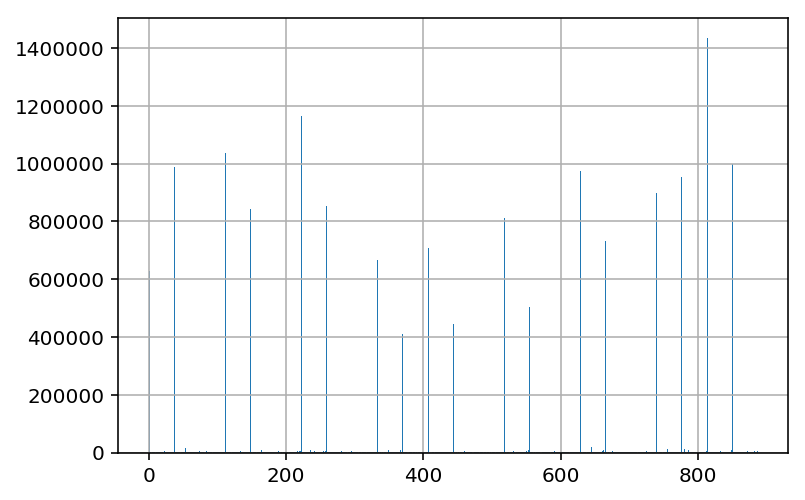

In [18]:
bus_data['tag_eqclass'].hist(bins = 888)
plt.show()

## Map tag equivalence class to hashtag

In [19]:
tag_map_df = pd.DataFrame.from_dict(tag_map, orient = 'index').reset_index()
tag_map_df.columns=['tagname','tagseq']
tag_map_df['hashtag'] = tag_map_df['tagname'].str.slice(start=0,stop=8)
tag_map_df.head()


,tagname,tagseq,hashtag
0,hashtagA-T,AGGACCATCCAAT,hashtagA
1,hashtagA-T-0-1,TGGACCATCCAAT,hashtagA
2,hashtagA-T-0-2,GGGACCATCCAAT,hashtagA
3,hashtagA-T-0-3,CGGACCATCCAAT,hashtagA
4,hashtagA-T-1-1,ATGACCATCCAAT,hashtagA


In [20]:
bus_data['tag']= bus_data['tag_eqclass'].map(tag_map_df['hashtag'])

In [21]:
bus_data.head()

,barcode,umi,tag_eqclass,multiplicity,tag
0,AAAAAAAAAAAAAAAA,AATAAACTTT,0,1,hashtagA
1,AAAAAAAAAACGAAAA,AAAAAAAAAA,259,1,hashtagH
2,AAAAAAAAACTGAACG,CGACTCTATA,74,1,hashtagC
3,AAAAAAAAGGCGAGGC,TGGCGTACCA,518,1,hashtagG
4,AAAAAAAAGTTCGGCG,GGCCAAAAAA,222,1,hashtagG


## See how many UMIs assigned to each hashtag

In [22]:
bus_data['tag'].value_counts()

hashtagG    3620200
hashtagD    3304874
hashtagB    2836998
hashtagF    2575345
hashtagH    2522968
hashtagE    2322790
hashtagC    2019601
hashtagA    1893351
Name: tag, dtype: int64

## Tally UMIs assigned to each cell barcode

In [23]:
print('Counting UMIs')
counted_data = bus_data.groupby(['barcode', 'tag'])['umi'].count().reset_index()
counted_data.rename(columns={'umi':'umi_counts'}, inplace = True)
counted_data.head()

Counting UMIs


,barcode,tag,umi_counts
0,AAAAAAAAAAAAAAAA,hashtagA,1
1,AAAAAAAAAACGAAAA,hashtagH,1
2,AAAAAAAAACTGAACG,hashtagC,1
3,AAAAAAAAGGCGAGGC,hashtagG,1
4,AAAAAAAAGTTCGGCG,hashtagG,1


## Saving `HTO_count_matrix.mtx` and labels to file

In [24]:
# encode barcode, umi and hashtags, which are strings, as ints
le_barcode = LabelEncoder()
barcode_idx =le_barcode.fit_transform(counted_data['barcode'].values)
print('Barcode index shape:', barcode_idx.shape)

le_umi = LabelEncoder()
umi_idx = le_umi.fit_transform(counted_data['umi_counts'].values)
print('UMI index shape:', umi_idx.shape)

le_tag = LabelEncoder()
tag_idx = le_tag.fit_transform(counted_data['tag'].values)
print('Tag index shape:', tag_idx.shape)

Barcode index shape: (2094925,)
UMI index shape: (2094925,)
Tag index shape: (2094925,)


In [25]:
# convert data to csr matrix
csr_matrix_data = scipy.sparse.csr_matrix((counted_data['umi_counts'].values,(barcode_idx,tag_idx)))

In [26]:
scipy.io.mmwrite(os.path.join(write_folder,'HTO_count_matrix.mtx'),csr_matrix_data)
print('Saved sparse csr matrix')

Saved sparse csr matrix


In [27]:
pd.DataFrame(le_tag.classes_).to_csv(os.path.join(write_folder,'HTO_tag_labels.csv'), index = False, header = False)
pd.DataFrame(le_barcode.classes_).to_csv(os.path.join(write_folder,'HTO_barcode_labels.csv'), index = False, header = False)
print('Saved cell barcode and hashtag labels')
print('Number of unique cell barcodes seen:', len(le_barcode.classes_))

Saved cell barcode and hashtag labels
Number of unique cell barcodes seen: 1376870


In [28]:
kallisto_finish_time=time.time()
print ('kite run time was ', int(kallisto_finish_time-notebook_start_time),'seconds')

kite run time was  123 seconds


## Loading `HTO_count_matrix.mtx` into a dataframe

In [29]:
kallisto_HTO_counts = pd.DataFrame(scipy.io.mmread(os.path.join(write_folder,'HTO_count_matrix.mtx')).toarray())
kallisto_HTO_counts.index=pd.read_csv(os.path.join(write_folder,'HTO_barcode_labels.csv'), header = None, squeeze = True, names = ['barcode'])
kallisto_HTO_counts.columns=pd.read_csv(os.path.join(write_folder,'HTO_tag_labels.csv'), header = None, squeeze = True)
kallisto_HTO_counts.head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH
barcode,,,,,,,,
AAAAAAAAAAAAAAAA,1,0,0,0,0,0,0,0
AAAAAAAAAACGAAAA,0,0,0,0,0,0,0,1
AAAAAAAAACTGAACG,0,0,1,0,0,0,0,0
AAAAAAAAGGCGAGGC,0,0,0,0,0,0,1,0
AAAAAAAAGTTCGGCG,0,0,0,0,0,0,1,0


## Run citeseq-count with SRR8281307


In [30]:
citeseq_count_start_time=time.time()
!CITE-seq-Count -R1 /home/munfred/hashing/data/SRR8281307_1.fastq.gz -R2 /home/munfred/hashing/data/SRR8281307_2.fastq.gz \
-t /home/munfred/hashing/kite/HTOs_len13.csv -cbf 1 -cbl 16 -umif 17 -umil 26 \
-o ./citeseq_count_out -cells 50000
citeseq_count_end_time=time.time()
print('citeseq count runtime: ' + str(citeseq_count_end_time-citeseq_count_start_time))

[WARNING] Read1 length is 29bp but you are using 26bp for Cell and UMI barcodes combined.
This might lead to wrong cell attribution and skewed umi counts.

Counting number of reads
Started mapping
CITE-seq-Count is running with 88 cores.
Mapping done for process 402968. Processed 843,408 reads
Mapping done for process 402969. Processed 843,408 reads
Mapping done for process 402970. Processed 843,408 reads
Mapping done for process 402971. Processed 843,408 reads
Mapping done for process 402972. Processed 843,408 reads
Mapping done for process 402973. Processed 843,408 reads
Mapping done for process 402974. Processed 843,408 reads
Mapping done for process 402975. Processed 843,408 reads
Mapping done for process 402976. Processed 843,408 reads
Mapping done for process 402977. Processed 843,408 reads
Mapping done for process 402978. Processed 843,408 reads
Mapping done for process 402979. Processed 843,408 reads
Mapping done for process 402980. Processed 843,408 reads
Mapping done for proc

In [33]:
citeseq_HTO_counts = pd.DataFrame(scipy.io.mmread('./citeseq_count_out/read_count/matrix.mtx.gz').toarray())
citeseq_HTO_counts = citeseq_HTO_counts.T
citeseq_HTO_counts.index=pd.read_csv('./citeseq_count_out/umi_count/barcodes.tsv.gz', header = None, squeeze = True, names = ['barcode'], sep = '\t')
citeseq_HTO_counts.columns=pd.read_csv('./citeseq_count_out/umi_count/features.tsv.gz', header = None, squeeze = True, sep = '\t')
citeseq_HTO_counts.head()

,hashtagA-AGGACCATCCAA,hashtagB-ACATGTTACCGT,hashtagC-AGCTTACTATCC,hashtagD-TCGATAATGCGA,hashtagE-GAGGCTGAGCTA,hashtagF-GTGTGACGTATT,hashtagG-ACTGTCTAACGG,hashtagH-TATCACATCGGT,unmapped
barcode,,,,,,,,,
TAGAGCTAGTCTCGGC,10,73,22,24,12,21,58,28,2
GTACGTACAGTGGGAT,7,4,11,36,5,87,42,30,2
GTGAAGGCATATGCTG,26,12,54,46,30,31,21,16,0
TTGCCGTCATCTATGG,120,45,21,18,10,15,10,0,4
TTTACTGCAGACGCTC,0,16,2056,18,27,12,40,8,9


In [34]:
citeseq_HTO_counts = citeseq_HTO_counts.iloc[:, 0:8]
citeseq_HTO_counts.columns = ['hashtagA','hashtagB','hashtagC','hashtagD','hashtagE','hashtagF','hashtagG','hashtagH']
citeseq_HTO_counts = citeseq_HTO_counts.sort_index()
citeseq_HTO_counts.head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH
barcode,,,,,,,,
AAACCTGAGACTAAGT,6,52,61,43,4,15,43,6
AAACCTGAGATGGGTC,0,31,11,89,30,39,78,24
AAACCTGAGCACACAG,50,6,8,73,20,24,80,13
AAACCTGAGCATCATC,23,0,35,11701,15,48,87,7
AAACCTGAGCCAGGAT,14,30,16,76,20,9907,58,33


## Check if kallisto missed barcodes included in the official data

In [35]:
missing_barcodes = []
common_barcodes = []
for official_barcode in citeseq_HTO_counts.index:
    if official_barcode not in kallisto_HTO_counts.index:
        missing_barcodes.append(official_barcode)
    else:
        common_barcodes.append(official_barcode)
print(len(common_barcodes), ' barcodes from citeseq-count were found by kallisto')        
#print('kallisto did not find the following barcodes:', missing_barcodes)
print('kallisto did not find', len(missing_barcodes), 'barcodes')
print('Summary of barcode read counts')

count_summary = pd.concat([citeseq_HTO_counts.loc[missing_barcodes].sum(),\
           kallisto_HTO_counts.loc[common_barcodes].sum(),\
           citeseq_HTO_counts.loc[common_barcodes].sum()],\
           axis=1, sort=False)
count_summary.columns= ['missed', 'kallisto', 'citeseq', ]
count_summary.loc['total'] = count_summary.sum()
count_summary.head(10)

49925  barcodes from citeseq-count were found by kallisto
kallisto did not find 75 barcodes
Summary of barcode read counts


,missed,kallisto,citeseq
0,,,
hashtagA,249,1621150,5718002
hashtagB,194,2453232,9023977
hashtagC,426,1672592,5763073
hashtagD,765,2797047,9973689
hashtagE,36,1947190,7068812
hashtagF,359,2115882,7919520
hashtagG,427,2880639,10484002
hashtagH,219,2123154,7631836
total,2675,17610886,63582911


### Note: on citeseq-count numbers

It is a bit surprising that citeseq-count finds 63,529,500 barcodes (after supposedly collapsing repeated UMIs) because the dataset has 74,219,921 reads, so that's 85% of the total reads! kallisto aligned 71,707,467 reads, however after collapsing repeated UMIs (done by BUStools) we are left with 21,096,127 distinct reads (of which 17,612,262 have common barcodes with cite-seq), suggesting on average the same molecule is seen about 3.4 times (due to PCR amplification). If we assume PCR amplification is not biased (which is generally true) then our comparison of citeseq-count and kallisto done below will generally hold. My general impression is that citeseq-count counts are inflated by 3-4x compared to kallisto, but the proportions agree.    

Another issue is the fact that there are some negative values in the count matrix returned by citeseq-count, as can be seen below. This is caused by integer overflow because int16 was used for the count matrices, so the maximum number of counts supported is 32768, and if it's higher than that we'll get integer overflow and a negative value (see https://github.com/Hoohm/CITE-seq-Count/issues/40). So it is acceptable to just throw barcodes with negative numbers away (which we do when filtering by minimum number of counts) and do the analysis anyway.

## We do a filtering cutoff for barcodes with at least 500 counts (reads) as seen by citeseq-count
This is equivalent to ~150 counts as seen by kallisto (deduplicated reads). Let's visualize read count abundances with this thresold for kallisto and citeseq count

In [36]:
count_cutoff = 500
highcount_barcodes = citeseq_HTO_counts[citeseq_HTO_counts.sum(1)>count_cutoff].index


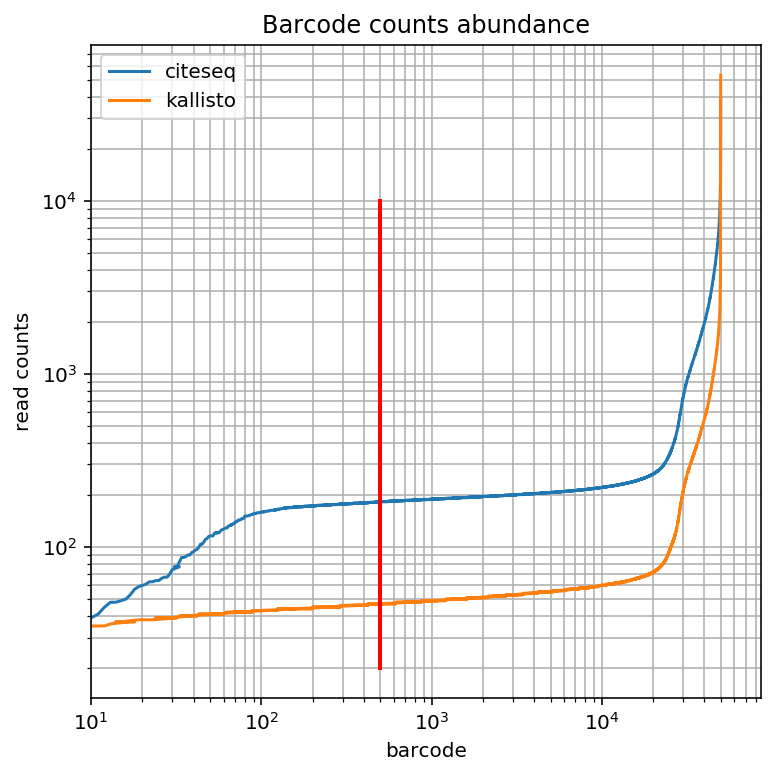

In [37]:
sorted_citeseq_total_counts = pd.Series(np.sort(citeseq_HTO_counts.loc[common_barcodes].sum(1)))
sorted_citeseq_total_counts = sorted_citeseq_total_counts[sorted_citeseq_total_counts>10].sort_values(ascending=False)
ax1 = sorted_citeseq_total_counts.plot(logy = True, logx = True, grid = True, figsize = (6,6), label="citeseq")
sorted_kallisto_total_counts = pd.Series(np.sort(kallisto_HTO_counts.loc[common_barcodes].sum(1)))
sorted_kallisto_total_counts = sorted_kallisto_total_counts[sorted_kallisto_total_counts>10].sort_values(ascending=False)
ax2 = sorted_kallisto_total_counts.plot(logy = True, logx = False,  label="kallisto")
plt.legend( loc='upper left')


plt.plot([count_cutoff, count_cutoff], [20, 10000], 'r-', lw=2)

plt.grid(True, which="both")
plt.xlim(left=10)
ax1.set(ylabel='read counts', xlabel='barcode', title = 'Barcode counts abundance')
plt.show()

## To make an apples to apples comparison, let's look at the barcodes seen in both kallisto and the official data

In [38]:
pd.DataFrame([kallisto_HTO_counts.loc[highcount_barcodes].sum(axis=1).describe(), citeseq_HTO_counts.loc[highcount_barcodes].sum(axis=1).describe()], index = ['kallisto processed', 'citeseq-count'])

,count,mean,std,min,25%,50%,75%,max
kallisto processed,21839.0,709.265168,735.609277,101.0,312.0,498.0,890.0,53265.0
citeseq-count,21839.0,2591.151472,2388.670177,501.0,1109.0,1792.0,3227.5,39618.0


## Simple tally:  ascribe the cell barcode to the hashtag that has the most counts 
They agree really well despite the citeseq-count apparent issues

In [39]:
pd.DataFrame([kallisto_HTO_counts.loc[highcount_barcodes].idxmax(axis = 1).value_counts(),citeseq_HTO_counts.loc[highcount_barcodes].idxmax(axis = 1).value_counts()], index = ['kallisto processed', 'citeseq-count'])

,hashtagB,hashtagG,hashtagD,hashtagH,hashtagC,hashtagA,hashtagE,hashtagF
kallisto processed,3187,3167,2749,2701,2696,2488,2434,2417
citeseq-count,3193,3152,2755,2706,2678,2496,2428,2431


# Make a confusion matrix
We assign the hashtag based on simple majority voting

In [40]:
kallisto_assigned_HTO = kallisto_HTO_counts.loc[highcount_barcodes]
kallisto_assigned_HTO['hashtag'] = kallisto_assigned_HTO.idxmax(axis = 1)
kallisto_assigned_HTO.head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag
barcode,,,,,,,,,
AAACCTGAGCATCATC,5,0,11,2866,4,7,21,2,hashtagD
AAACCTGAGCCAGGAT,4,8,3,20,7,2504,14,5,hashtagF
AAACCTGAGGCCCTCA,429,6,2,3,5,5,21,5,hashtagA
AAACCTGAGGCTACGA,2,6,5,8,7,5,5,517,hashtagH
AAACCTGAGGTGCAAC,0,336,3,6,4,14,16,7,hashtagB


In [41]:
citeseq_assigned_HTO = citeseq_HTO_counts.loc[highcount_barcodes]
#assign chosen hashtag by majority voting
citeseq_assigned_HTO['hashtag'] = citeseq_assigned_HTO.idxmax(axis = 1)
citeseq_assigned_HTO.head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag
barcode,,,,,,,,,
AAACCTGAGCATCATC,23,0,35,11701,15,48,87,7,hashtagD
AAACCTGAGCCAGGAT,14,30,16,76,20,9907,58,33,hashtagF
AAACCTGAGGCCCTCA,1489,33,2,7,13,12,86,21,hashtagA
AAACCTGAGGCTACGA,7,34,23,28,22,20,28,1998,hashtagH
AAACCTGAGGTGCAAC,0,1206,6,26,11,43,53,22,hashtagB


In [42]:
assigned_hashtags = pd.DataFrame()
assigned_hashtags['kallisto_hashtag'] = kallisto_assigned_HTO['hashtag'].str.slice(7,9)
assigned_hashtags['citeseq_hashtag'] = citeseq_assigned_HTO['hashtag'].str.slice(7,9)
assigned_hashtags.head()

,kallisto_hashtag,citeseq_hashtag
barcode,,
AAACCTGAGCATCATC,D,D
AAACCTGAGCCAGGAT,F,F
AAACCTGAGGCCCTCA,A,A
AAACCTGAGGCTACGA,H,H
AAACCTGAGGTGCAAC,B,B


In [43]:
kallisto_assigned = assigned_hashtags['kallisto_hashtag'].values
citeseq_assigned = assigned_hashtags['citeseq_hashtag'].values
cnf_matrix = confusion_matrix(kallisto_assigned, citeseq_assigned)

In [44]:
ndiff_hashtags = np.sum (assigned_hashtags['kallisto_hashtag'] != assigned_hashtags['citeseq_hashtag'])
print('Number of barcodes with different assignments:', ndiff_hashtags)
print('This represents the following fraction of total barcodes:', ndiff_hashtags/len(citeseq_assigned_HTO ))

Number of barcodes with different assignments: 99
This represents the following fraction of total barcodes: 0.004533174595906406


In [45]:
# Compute confusion matrix

kallisto_assigned = assigned_hashtags['kallisto_hashtag'].values
citeseq_assigned = assigned_hashtags['citeseq_hashtag'].values
cnf_matrix = confusion_matrix(kallisto_assigned, citeseq_assigned)
cnf_matrix

array([[2485,    0,    0,    1,    0,    0,    1,    1],
       [   2, 3178,    0,    1,    0,    2,    4,    0],
       [   3,    4, 2671,    4,    2,    6,    3,    3],
       [   0,    1,    0, 2743,    0,    1,    3,    1],
       [   0,    6,    0,    1, 2422,    2,    0,    3],
       [   1,    3,    1,    0,    1, 2409,    1,    1],
       [   3,    1,    4,    5,    2,   11, 3138,    3],
       [   2,    0,    2,    0,    1,    0,    2, 2694]])

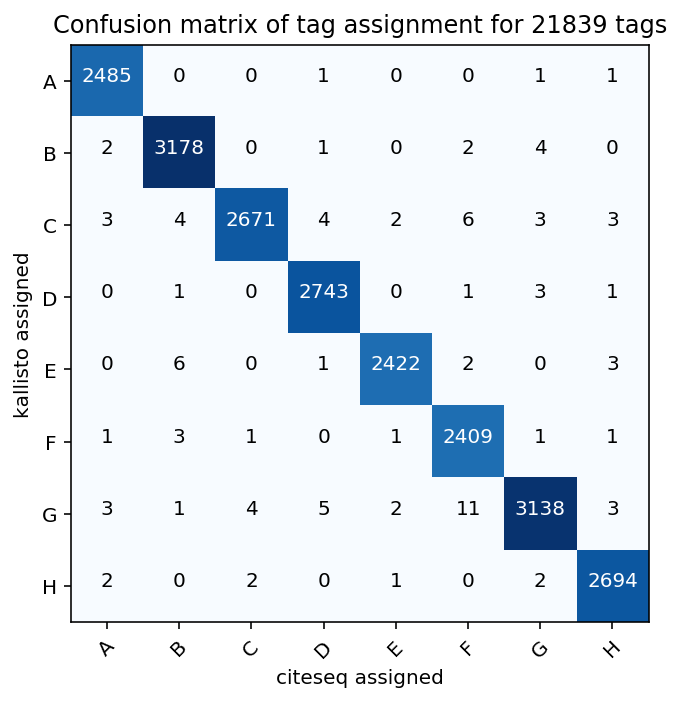

In [46]:
np.set_printoptions(precision=2)
import itertools    
cm = cnf_matrix
classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
figure(figsize = (5,5))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix of tag assignment for ' + str(len(kallisto_assigned)) + ' tags')
plt.ylabel('kallisto assigned')
plt.xlabel('citeseq assigned')
plt.tight_layout()
plt.savefig("confusion_matrix.svg", format="svg")
plt.show()

# Take a look at the mismathing tags assigned
All of them have a high number of counts for two tags, with quite close values. These are likely doublets.

In [47]:
pd.concat([kallisto_assigned_HTO[assigned_hashtags['kallisto_hashtag'] != assigned_hashtags['citeseq_hashtag']],\
           citeseq_assigned_HTO[assigned_hashtags['kallisto_hashtag'] != assigned_hashtags['citeseq_hashtag']]],\
           axis=1, sort=False).head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag
barcode,,,,,,,,,,,,,,,,,,
AAAGATGCAAAGGTGC,2,3,2,1,2,212,246,7,hashtagG,14,8,9,1,7,821,819,26,hashtagF
AAAGTAGGTTCCACGG,6,9,7,5,3,736,845,12,hashtagG,26,25,28,18,11,2924,2846,44,hashtagF
AACGTTGCACACATGT,36,4,7,18,20,13,30,18,hashtagA,125,16,22,65,82,70,143,71,hashtagG
AACTGGTTCCACGCAG,8,13,25,27,13,20,28,15,hashtagG,43,55,96,105,54,71,101,57,hashtagD
AAGGCAGAGAATTGTG,10,249,5,15,17,257,41,13,hashtagF,40,1005,14,67,68,908,133,45,hashtagB


## Plot embeddings
For plotting we ascibe to each barcode the most abundant hashtag

We make a custom colormap with two different hues for the kallisto and official data, and a different color for each hashtag

We concatenate both kallisto processed and the official count matrix to embed and plot them in the same space

We also define a helper function to make nice labeled plots of the clusters. Because we're plotting 130k points it's hard to visualize marker shapes, so we use different color hues for kallist processed and official processed 

In [48]:
#define a colormap for plotting nicely
kallisto_colormap={'hashtagA':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
          'hashtagB':(1.0, 0.4980392156862745, 0.054901960784313725),
          'hashtagC':(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
          'hashtagD':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
          'hashtagE':(0.5803921568627451, 0.403921568627451, 0.7411764705882353),
          'hashtagF':(0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
          'hashtagG':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
          'hashtagH':(0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
         }
official_colormap={'hashtagA':(0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
        'hashtagB':(1.0, 0.7333333333333333, 0.47058823529411764),
        'hashtagC':(0.596078431372549, 0.8745098039215686, 0.5411764705882353),
        'hashtagD':(1.0, 0.596078431372549, 0.5882352941176471),
        'hashtagE':(0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
        'hashtagF':(0.7686274509803922, 0.611764705882353, 0.5803921568627451),
        'hashtagG':(0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
        'hashtagH':(0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
       }

In [49]:
kallisto_common_HTO = kallisto_HTO_counts.loc[highcount_barcodes]
kallisto_common_HTO.index = kallisto_common_HTO.index+'_kallisto' 
kallisto_common_HTO['hashtag'] = kallisto_common_HTO.idxmax(axis = 1)
kallisto_common_HTO['color'] = kallisto_common_HTO['hashtag'].map(kallisto_colormap)
kallisto_common_HTO.head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag,color
AAACCTGAGCATCATC_kallisto,5,0,11,2866,4,7,21,2,hashtagD,"(0.8392156862745098, 0.15294117647058825, 0.15..."
AAACCTGAGCCAGGAT_kallisto,4,8,3,20,7,2504,14,5,hashtagF,"(0.5490196078431373, 0.33725490196078434, 0.29..."
AAACCTGAGGCCCTCA_kallisto,429,6,2,3,5,5,21,5,hashtagA,"(0.12156862745098039, 0.4666666666666667, 0.70..."
AAACCTGAGGCTACGA_kallisto,2,6,5,8,7,5,5,517,hashtagH,"(0.4980392156862745, 0.4980392156862745, 0.498..."
AAACCTGAGGTGCAAC_kallisto,0,336,3,6,4,14,16,7,hashtagB,"(1.0, 0.4980392156862745, 0.054901960784313725)"


In [50]:
official_common_HTO = citeseq_HTO_counts.loc[highcount_barcodes]
official_common_HTO.index = official_common_HTO.index+'_official' 
#assign chosen hashtag by majority voting
official_common_HTO['hashtag'] = official_common_HTO.idxmax(axis = 1)
official_common_HTO['color'] = official_common_HTO['hashtag'].map(official_colormap)
official_common_HTO.head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag,color
AAACCTGAGCATCATC_official,23,0,35,11701,15,48,87,7,hashtagD,"(1.0, 0.596078431372549, 0.5882352941176471)"
AAACCTGAGCCAGGAT_official,14,30,16,76,20,9907,58,33,hashtagF,"(0.7686274509803922, 0.611764705882353, 0.5803..."
AAACCTGAGGCCCTCA_official,1489,33,2,7,13,12,86,21,hashtagA,"(0.6823529411764706, 0.7803921568627451, 0.909..."
AAACCTGAGGCTACGA_official,7,34,23,28,22,20,28,1998,hashtagH,"(0.7803921568627451, 0.7803921568627451, 0.780..."
AAACCTGAGGTGCAAC_official,0,1206,6,26,11,43,53,22,hashtagB,"(1.0, 0.7333333333333333, 0.47058823529411764)"


In [51]:
joint_commmon_HTO = pd.DataFrame.append(kallisto_common_HTO, official_common_HTO)

In [52]:
joint_commmon_HTO.head()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag,color
AAACCTGAGCATCATC_kallisto,5,0,11,2866,4,7,21,2,hashtagD,"(0.8392156862745098, 0.15294117647058825, 0.15..."
AAACCTGAGCCAGGAT_kallisto,4,8,3,20,7,2504,14,5,hashtagF,"(0.5490196078431373, 0.33725490196078434, 0.29..."
AAACCTGAGGCCCTCA_kallisto,429,6,2,3,5,5,21,5,hashtagA,"(0.12156862745098039, 0.4666666666666667, 0.70..."
AAACCTGAGGCTACGA_kallisto,2,6,5,8,7,5,5,517,hashtagH,"(0.4980392156862745, 0.4980392156862745, 0.498..."
AAACCTGAGGTGCAAC_kallisto,0,336,3,6,4,14,16,7,hashtagB,"(1.0, 0.4980392156862745, 0.054901960784313725)"


In [53]:
joint_commmon_HTO.tail()

,hashtagA,hashtagB,hashtagC,hashtagD,hashtagE,hashtagF,hashtagG,hashtagH,hashtag,color
TTTGTCATCATCGGAT_official,1084,33,3,49,20,23,36,19,hashtagA,"(0.6823529411764706, 0.7803921568627451, 0.909..."
TTTGTCATCCGAGCCA_official,10,11,16,20,2088,30,77,14,hashtagE,"(0.7725490196078432, 0.6901960784313725, 0.835..."
TTTGTCATCTAACTGG_official,0,7,0,48,1953,28,19,26,hashtagE,"(0.7725490196078432, 0.6901960784313725, 0.835..."
TTTGTCATCTGACCTC_official,4068,15,21,57,31,51,22,15,hashtagA,"(0.6823529411764706, 0.7803921568627451, 0.909..."
TTTGTCATCTGCTGCT_official,7,22,4,19,26,5013,59,31,hashtagF,"(0.7686274509803922, 0.611764705882353, 0.5803..."


In [54]:
def plot_labeled_clusters(embedding,joint_commmon_HTO=joint_commmon_HTO, title = 'Embedding of kallisto and official processed HTO samples'):
    #create a new figure
    split = int(len(joint_commmon_HTO)/2)
    plt.figure(num=None, figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')

    #loop through labels and plot each cluster
    for i, hashtag in enumerate(joint_commmon_HTO.loc[:,'hashtagA':'hashtagH'].keys()):

        #add data points 
        plt.scatter(x=embedding[:split][:,0][joint_commmon_HTO[:split]['hashtag']==hashtag], 
                    y=embedding[:split][:,1][joint_commmon_HTO[:split]['hashtag']==hashtag], 
                    color=kallisto_colormap[hashtag], 
                    marker='.', alpha=0.8, s = 0.5)

        #add label
        plt.annotate(hashtag[-1]+'k', 
                     embedding[:split][joint_commmon_HTO[:split]['hashtag']==hashtag].mean(0),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20,
                     color=kallisto_colormap[hashtag]) 

    #loop through labels and plot each cluster
    for i, hashtag in enumerate(joint_commmon_HTO.loc[:,'hashtagA':'hashtagH'].keys()):

        #add data points 
        ax = plt.scatter(x=embedding[split:][:,0][joint_commmon_HTO[split:]['hashtag']==hashtag], 
                    y=embedding[split:][:,1][joint_commmon_HTO[split:]['hashtag']==hashtag], 
                    color=official_colormap[hashtag], 
                    marker='.', alpha=0.8, s = 0.5)

        #add label
        plt.annotate(hashtag[-1]+'o', 
                     embedding[split:][joint_commmon_HTO[split:]['hashtag']==hashtag].mean(0),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20,
                     color=official_colormap[hashtag]) 

    plt.title(title)
    plt.show()

## Truncated SVD

In [55]:
tsvd = TruncatedSVD(n_components=2)
tsvd_embedding = tsvd.fit_transform(np.log1p(joint_commmon_HTO.loc[:,'hashtagA':'hashtagH'].values))
tsvd_embedding

array([[ 7.31, -2.69],
       [ 8.16, -0.2 ],
       [ 6.5 , -0.87],
       ...,
       [ 8.34, -0.37],
       [10.78, -1.82],
       [10.51,  0.03]])

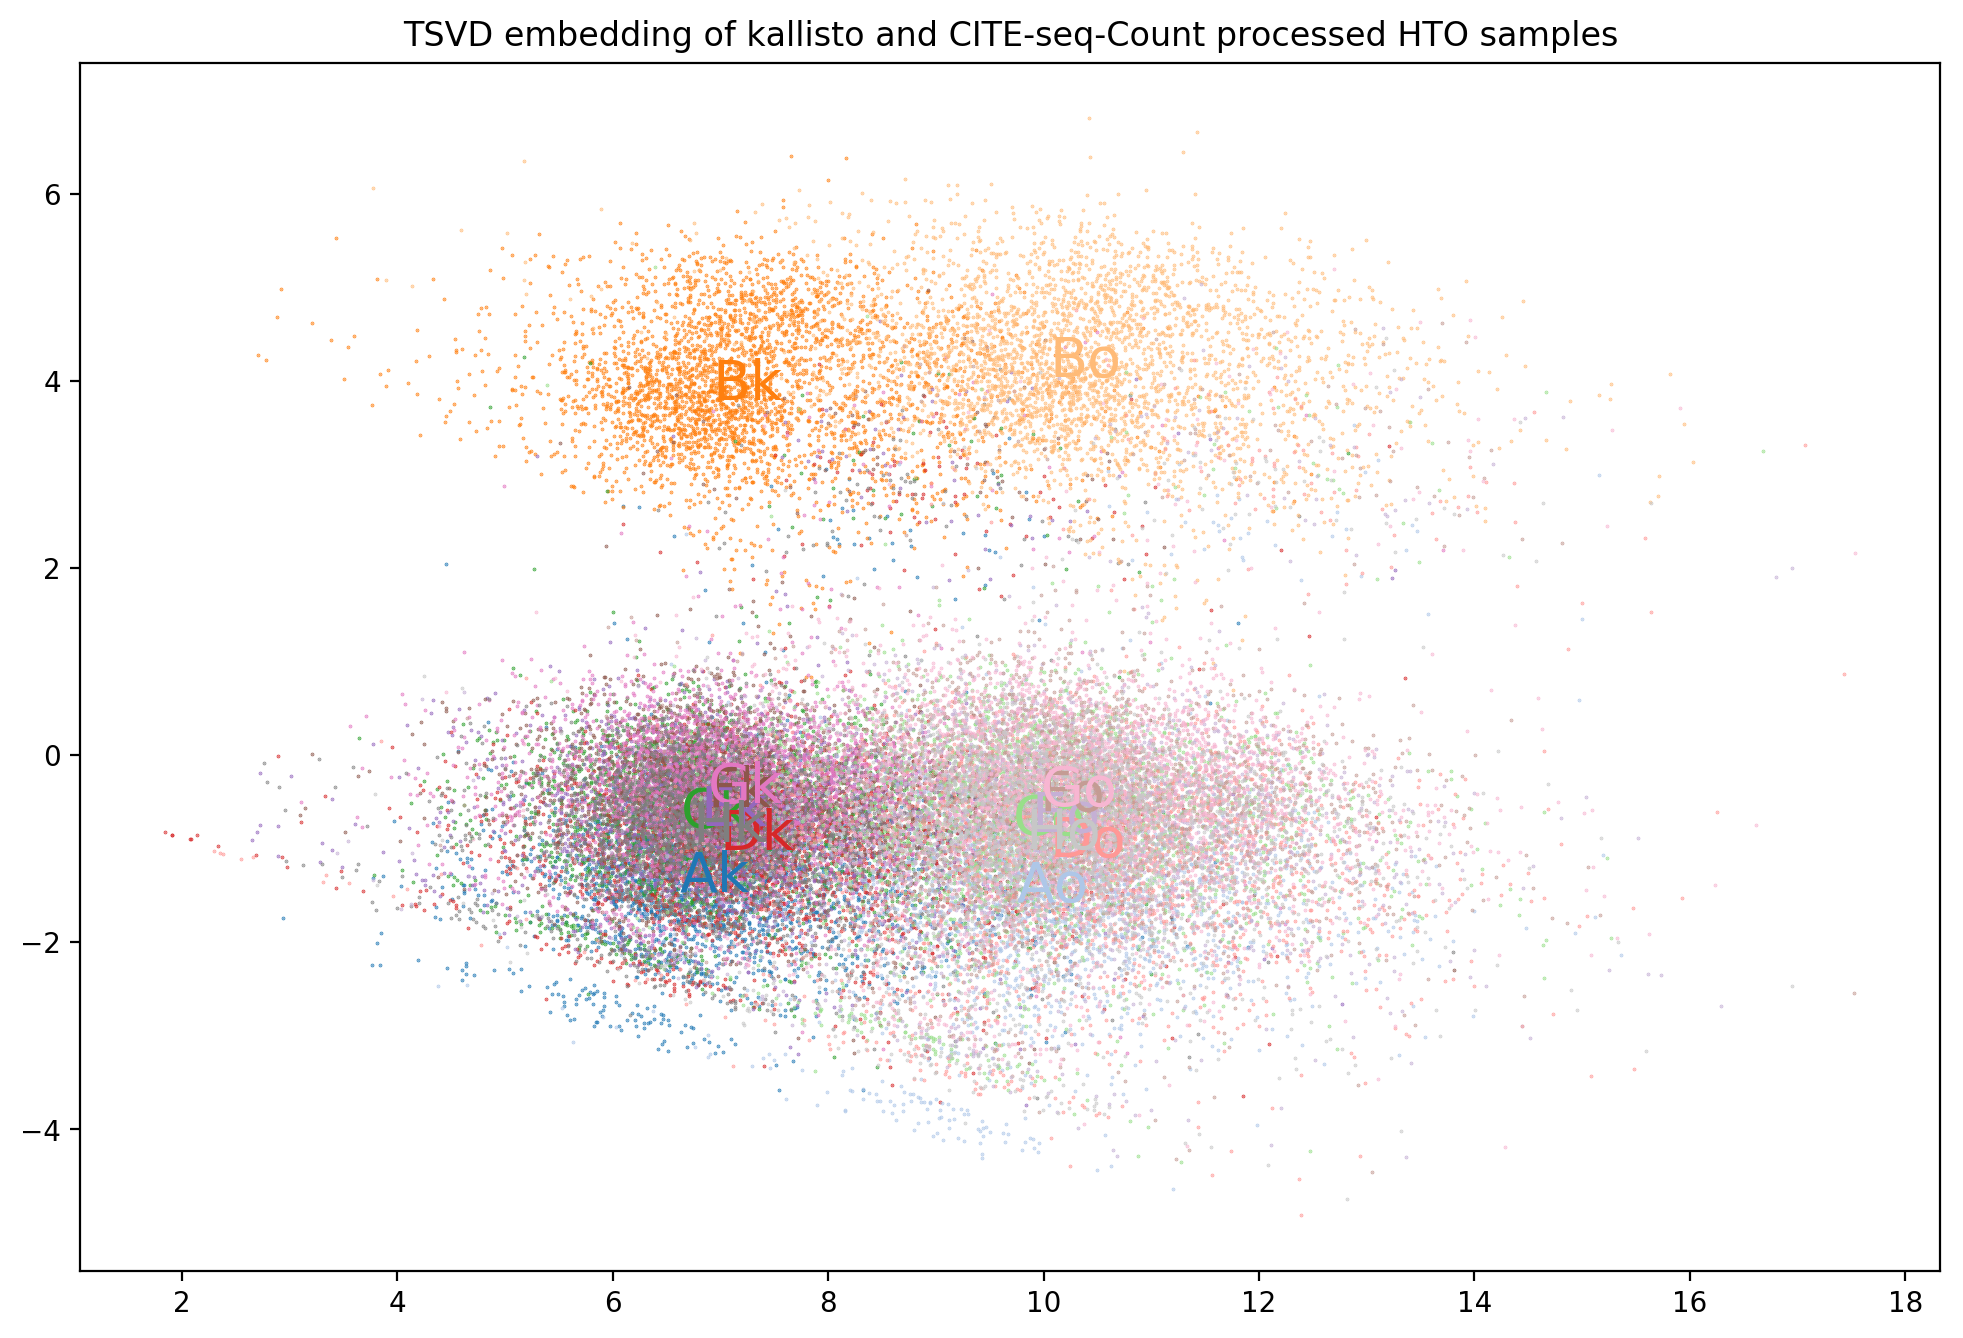

In [56]:
plot_labeled_clusters(embedding = tsvd_embedding, joint_commmon_HTO =  joint_commmon_HTO, \
                      title = 'TSVD embedding of kallisto and CITE-seq-Count processed HTO samples')

## PCA

In [57]:
pca = sklearn.decomposition.PCA(n_components=2)
pca_embedding = pca.fit_transform(np.log1p(joint_commmon_HTO.loc[:,'hashtagA':'hashtagH'].fillna(0).values))
pca_embedding

array([[-2.28, -1.93],
       [-0.63,  0.08],
       [-1.8 , -0.37],
       ...,
       [-0.53, -0.1 ],
       [ 2.06, -3.  ],
       [ 1.53, -0.54]])

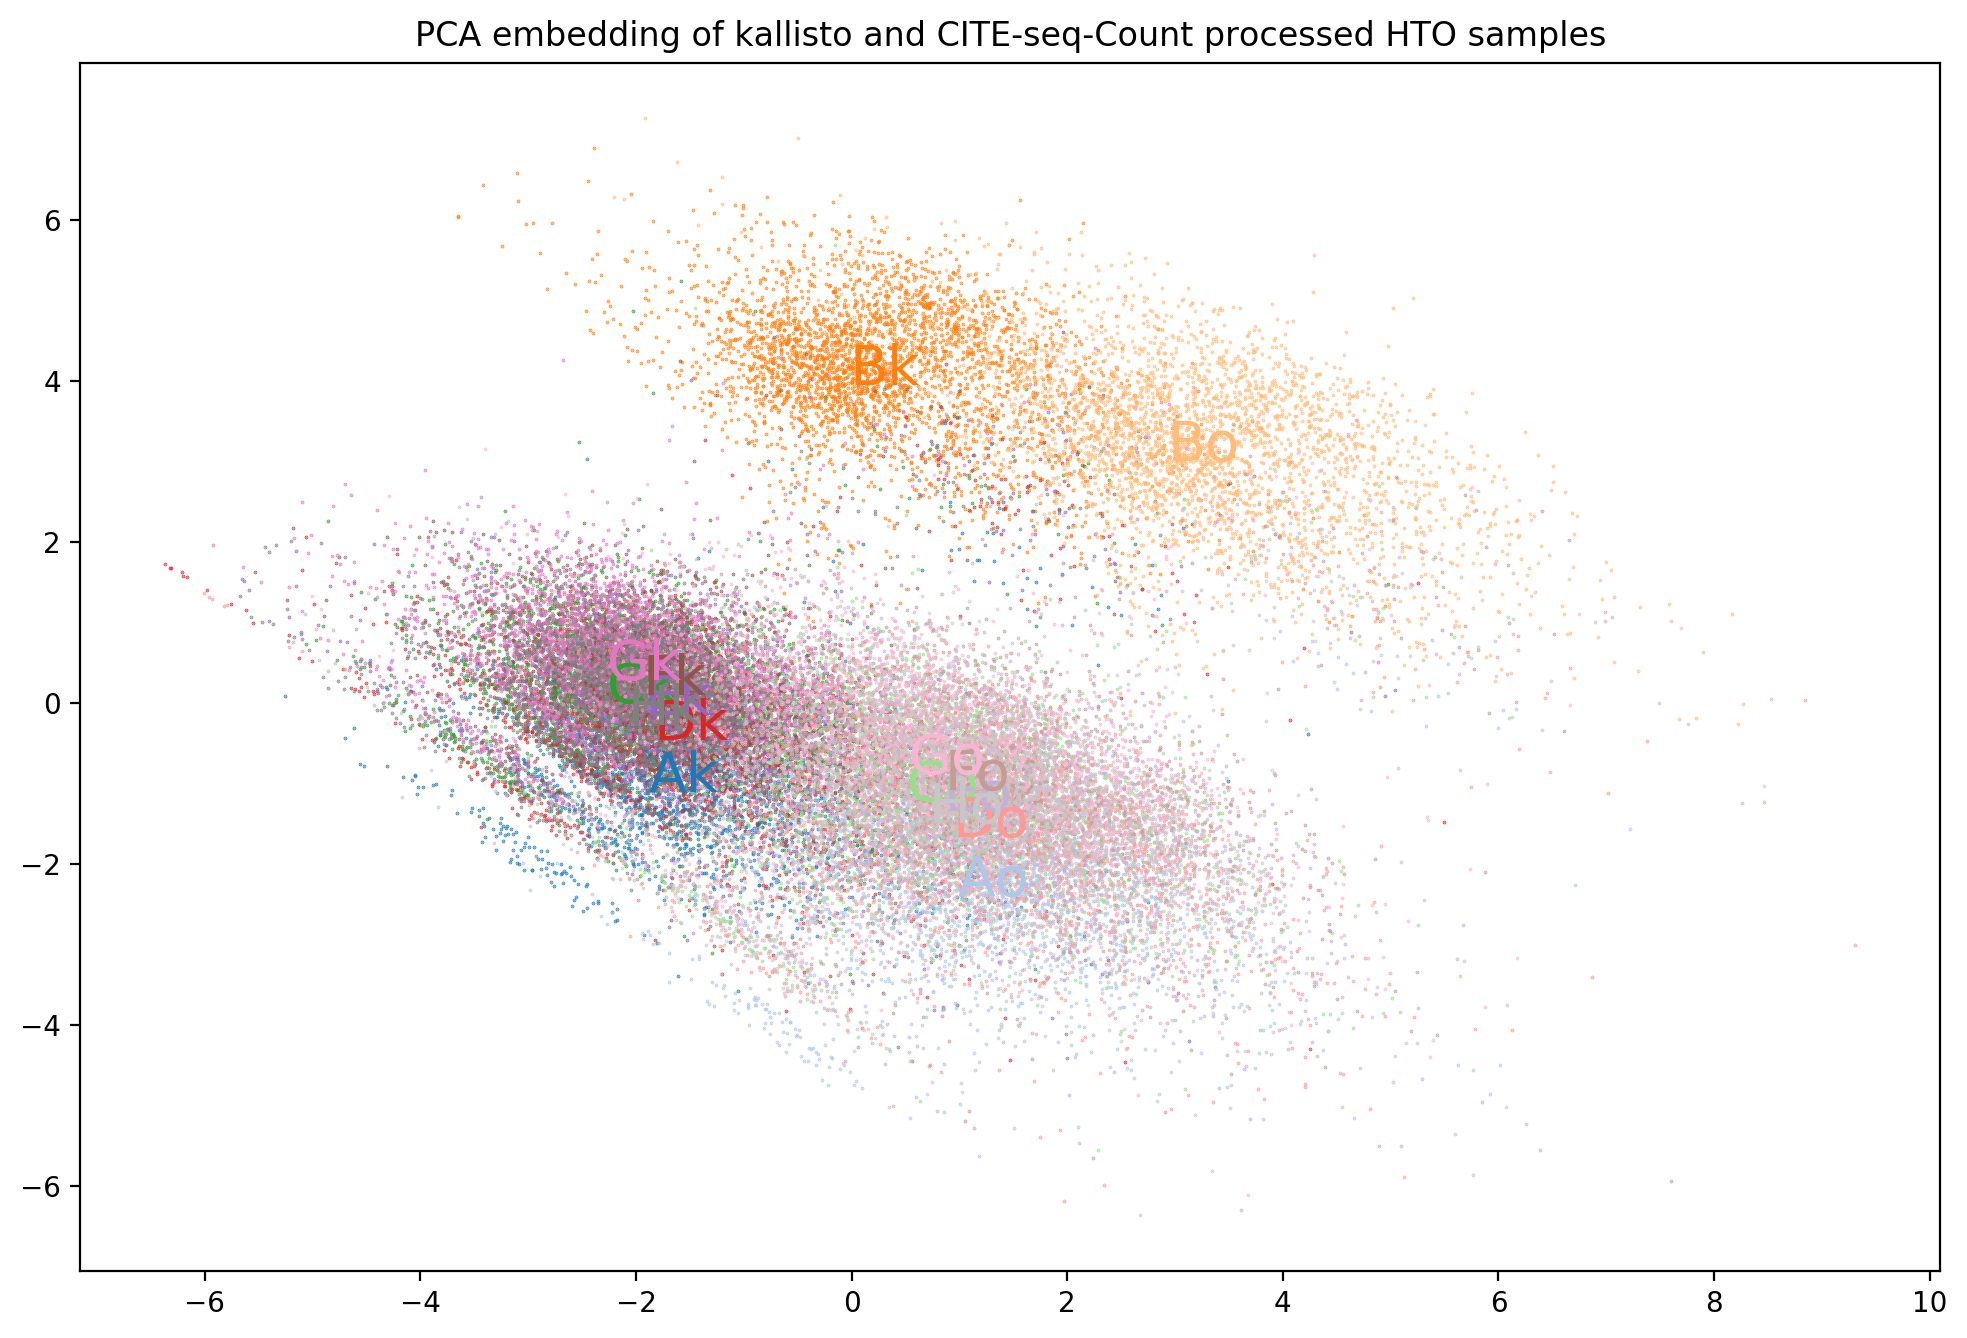

In [58]:
plot_labeled_clusters(embedding = pca_embedding, joint_commmon_HTO = joint_commmon_HTO, \
                      title = 'PCA embedding of kallisto and CITE-seq-Count processed HTO samples')

## UMAP

In [59]:
umap_embedding = umap.UMAP().fit_transform(np.log1p(joint_commmon_HTO.loc[:,'hashtagA':'hashtagH'].values))
umap_embedding

array([[-12.38,   1.55],
       [ -6.6 ,  -4.26],
       [ -2.27, -10.71],
       ...,
       [  1.43,  -2.42],
       [ -1.49,  -7.63],
       [ -5.48,  -3.3 ]], dtype=float32)

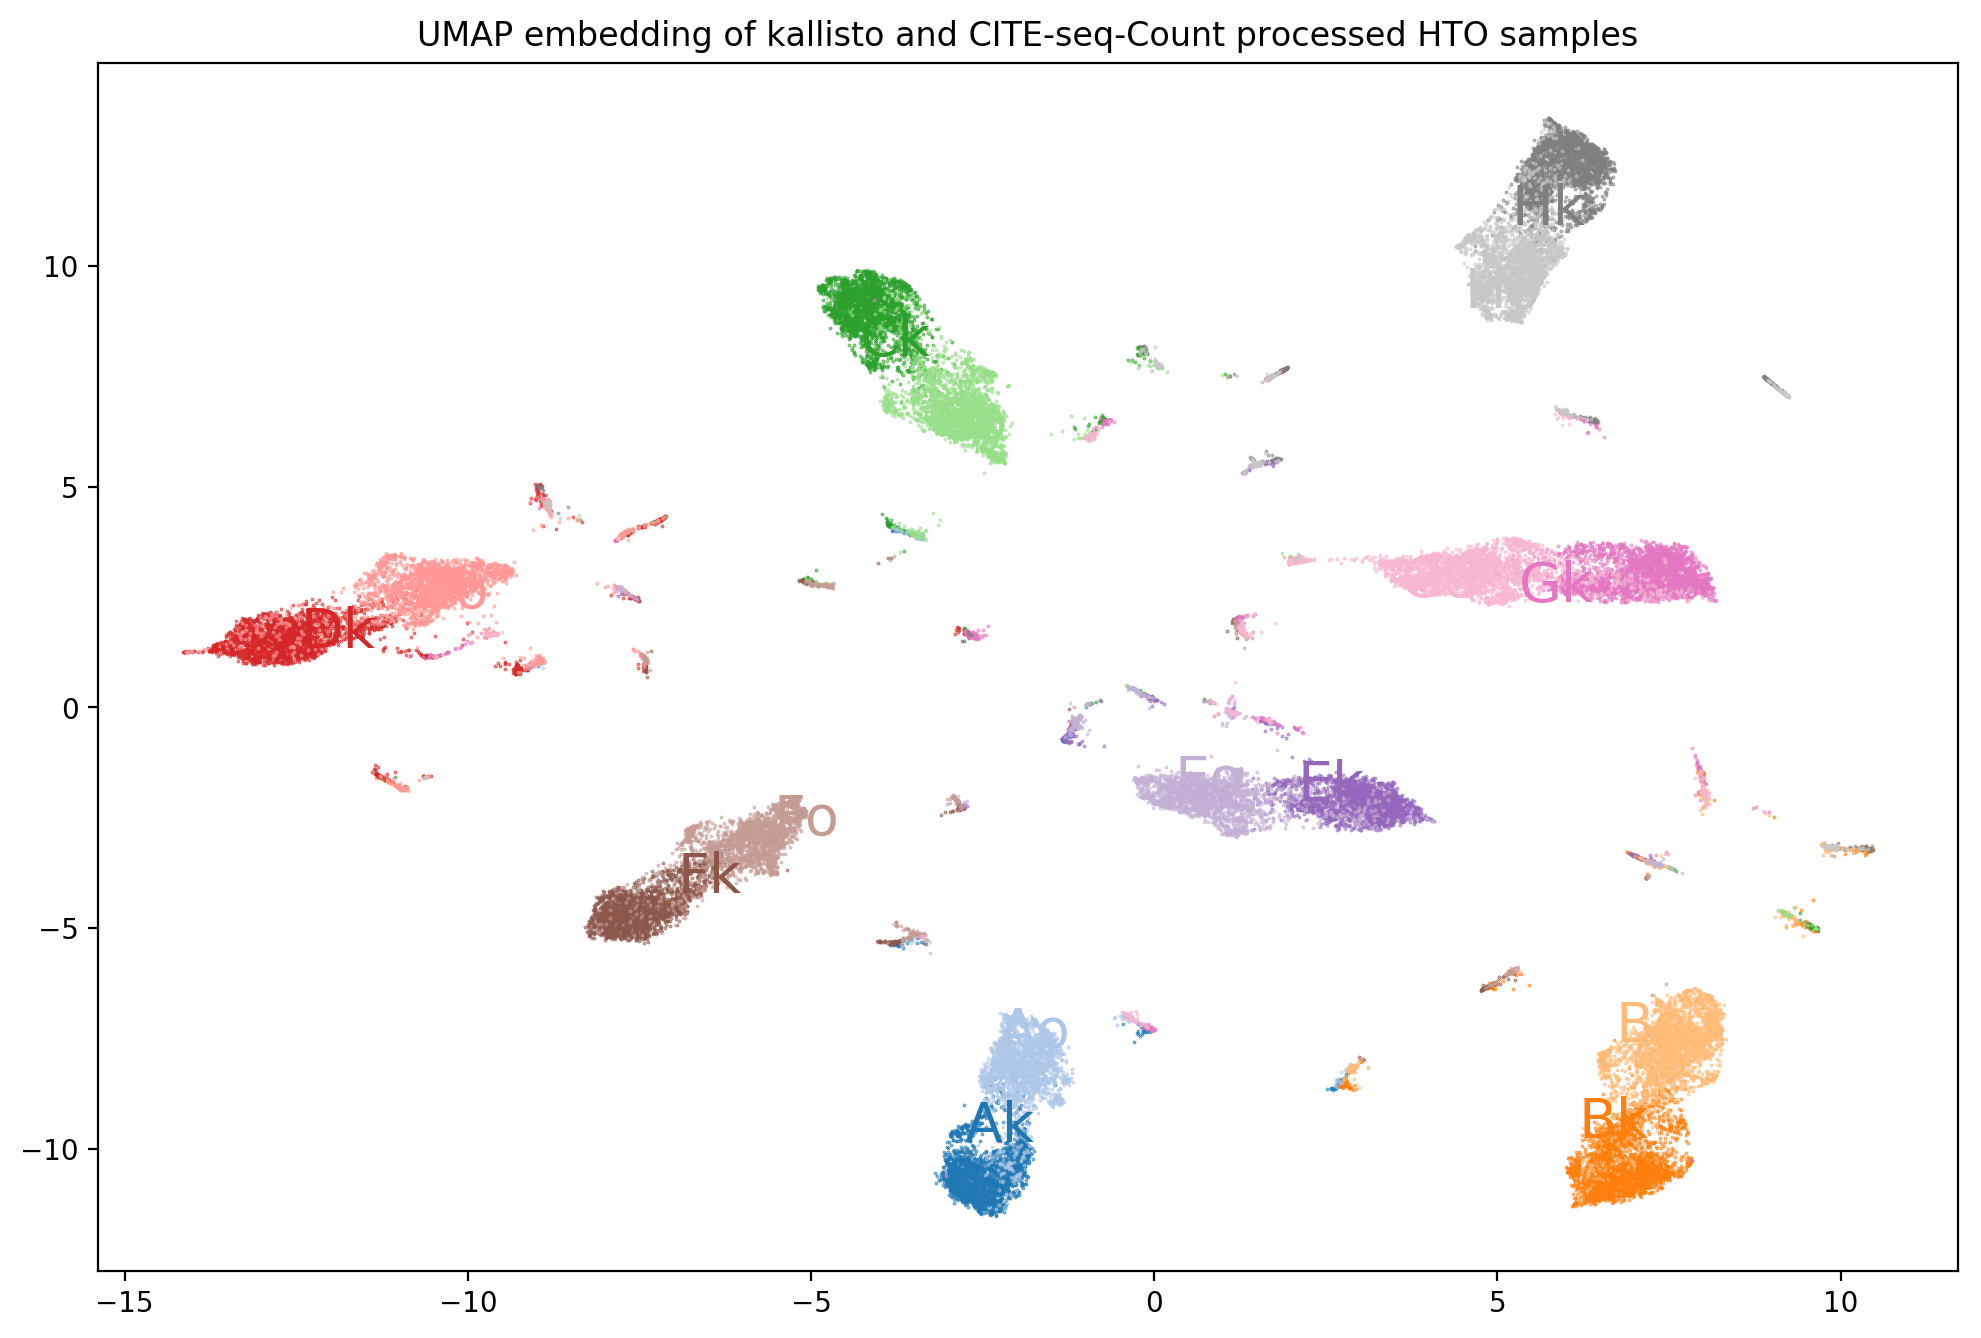

In [60]:
plot_labeled_clusters(embedding = umap_embedding, joint_commmon_HTO = joint_commmon_HTO,\
                      title = 'UMAP embedding of kallisto and CITE-seq-Count processed HTO samples')

## UMAP without first log transforming

In [61]:
umap_embedding_not_log = umap.UMAP().fit_transform((joint_commmon_HTO.loc[:,'hashtagA':'hashtagH'].values))
umap_embedding_not_log

array([[-11.84,   8.28],
       [ -7.6 ,  -2.53],
       [  6.16,   2.8 ],
       ...,
       [ -7.22,  -6.58],
       [ -7.64,  -0.11],
       [-10.4 ,  -3.67]], dtype=float32)

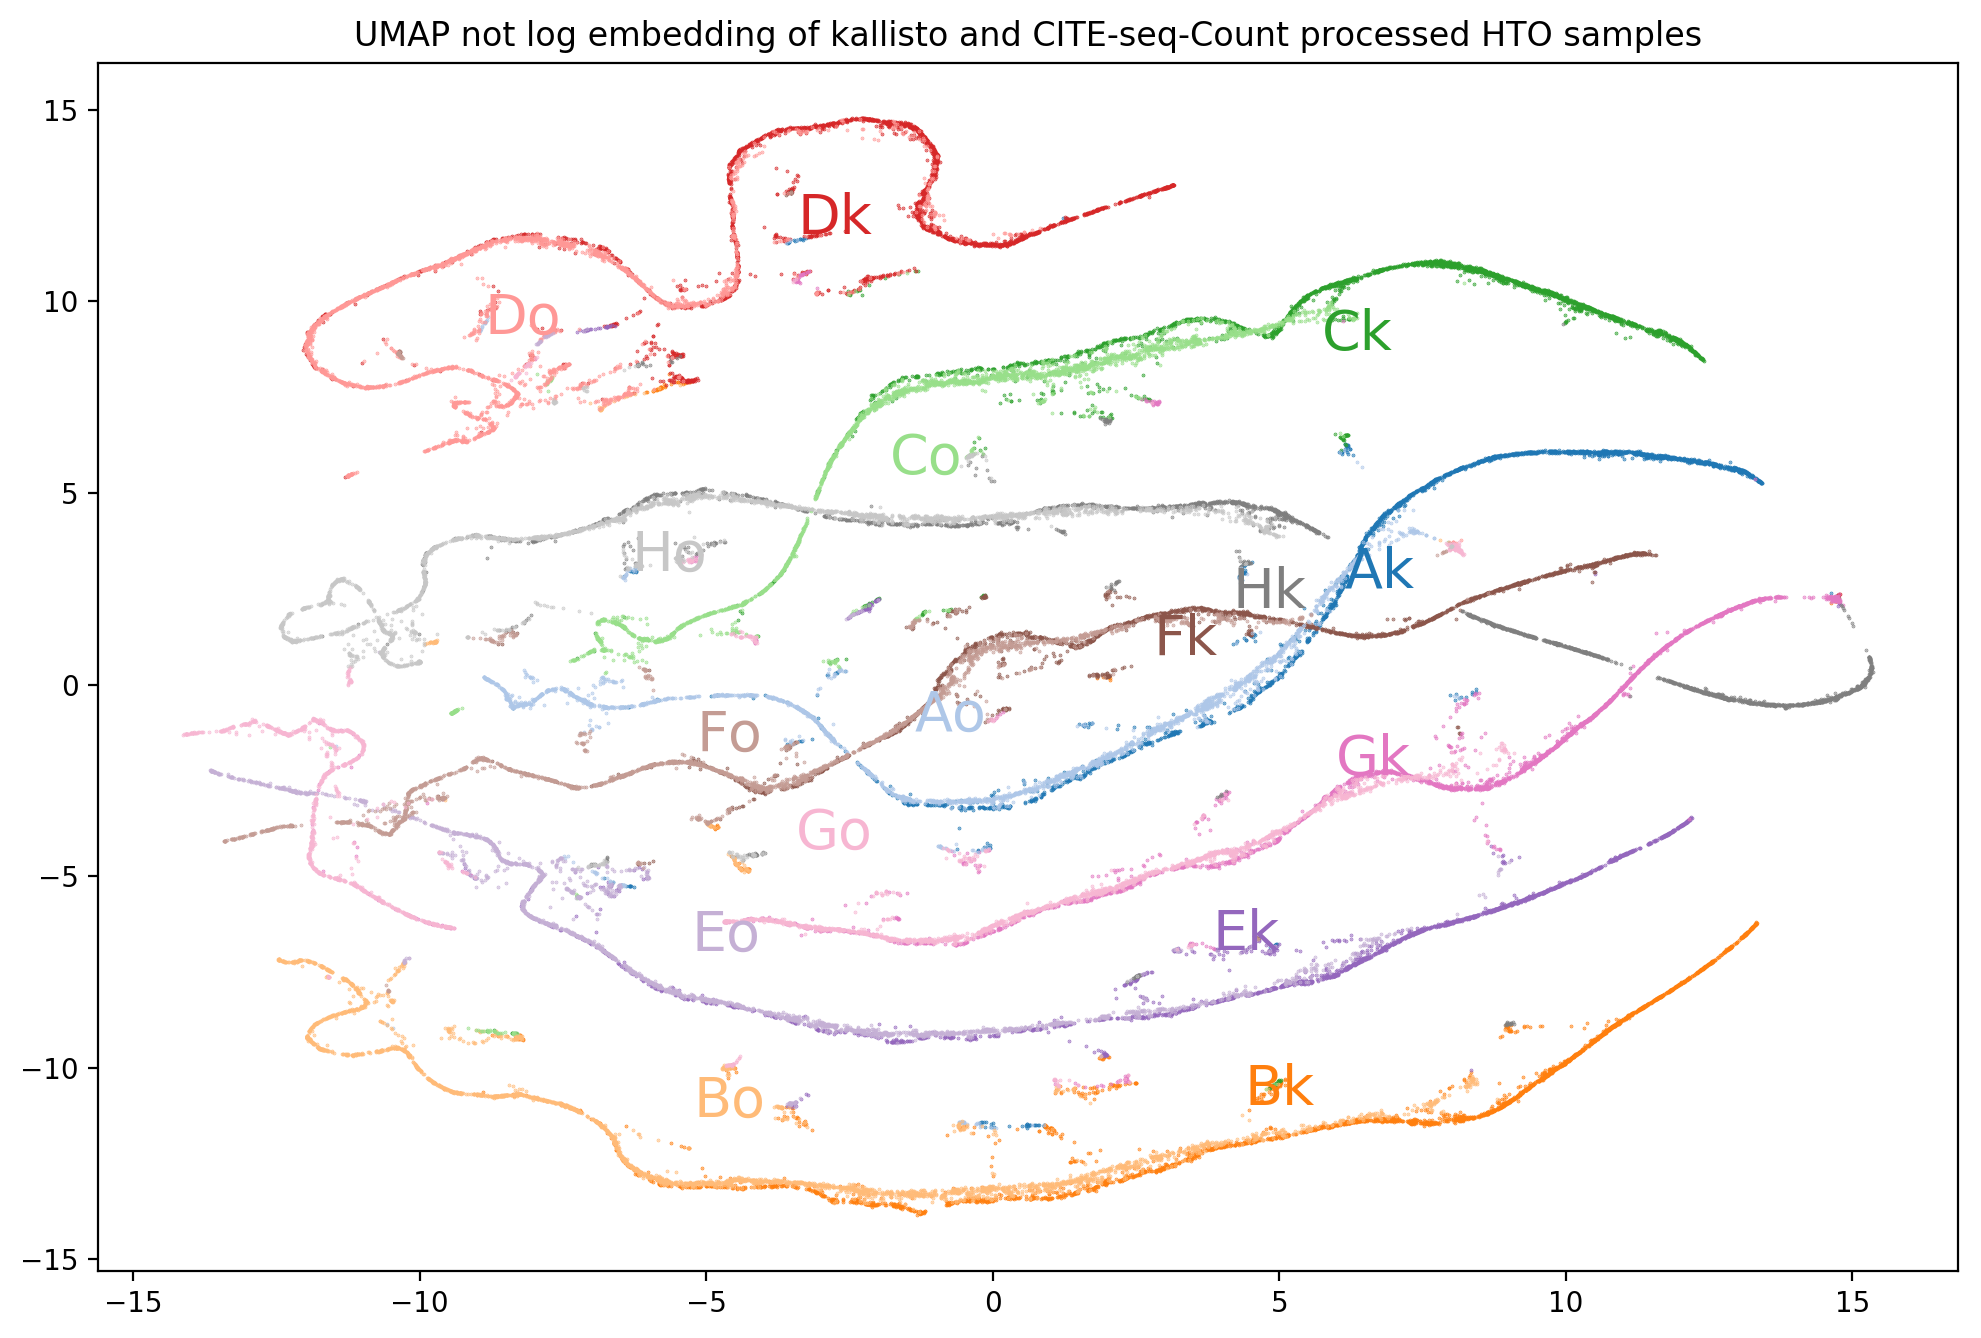

In [62]:
plot_labeled_clusters(embedding = umap_embedding_not_log, joint_commmon_HTO = joint_commmon_HTO,\
                      title = 'UMAP not log embedding of kallisto and CITE-seq-Count processed HTO samples')

## t-SNE

In [63]:
tsne_embedding = sklearn.manifold.TSNE(n_components=2).fit_transform(np.log1p(joint_commmon_HTO.loc[:,'hashtagA':'hashtagH'].values))
tsne_embedding.shape

(43678, 2)

In [64]:
plot_labeled_clusters(embedding = tsne_embedding, joint_commmon_HTO = joint_commmon_HTO, \
                      title = 't-SNE embedding of kallisto and CITE-seq-Count processed HTO samples')

TypeError: plot_labeled_clusters() got an unexpected keyword argument 'split'